In [1]:
import tensorflow as tf
import tensorflow.keras.layers as layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import load_model

In [2]:
train, test = tf.keras.datasets.fashion_mnist.load_data()
images, labels = train

X_train, X_test, y_train, y_test = \
    train_test_split(images, labels, test_size=0.1, random_state=10, stratify=labels)

X_train, X_val, y_train, y_val = \
    train_test_split(X_train, y_train, test_size=0.3, random_state=10, stratify=y_train)

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))

batch_size=32

In [3]:
AUTOTUNE = tf.data.AUTOTUNE
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = (image / 255.0)
    image = tf.image.resize(image, (28, 28))
    return image, label

def augment(image, label):
    image, label = resize_and_rescale(image, label)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_flip_left_right(image)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

train_ds = (
    train_ds
    .shuffle(3000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [4]:
model_1 = tf.keras.Sequential([
    layers.Flatten(input_shape=[28, 28, 1]),
    layers.Dense(500, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(300, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(10, activation='softmax')
])

adam_optim = keras.optimizers.Adam(learning_rate=0.001)

model_1.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=adam_optim,
    metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001)

In [5]:
train_model = model_1.fit(train_ds, epochs=50,  batch_size=32, verbose=1, callbacks=[reduce_lr], validation_data=val_ds)

Epoch 1/50
1182/1182 [==============================] - 15s 12ms/step - loss: 0.6650 - accuracy: 0.7548 - val_loss: 0.4967 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 2/50
1182/1182 [==============================] - 13s 11ms/step - loss: 0.4978 - accuracy: 0.8196 - val_loss: 0.4766 - val_accuracy: 0.8243 - lr: 0.0010
Epoch 3/50
1182/1182 [==============================] - 17s 14ms/step - loss: 0.4602 - accuracy: 0.8320 - val_loss: 0.4264 - val_accuracy: 0.8491 - lr: 0.0010
Epoch 4/50
1182/1182 [==============================] - 15s 13ms/step - loss: 0.4310 - accuracy: 0.8435 - val_loss: 0.4110 - val_accuracy: 0.8495 - lr: 0.0010
Epoch 5/50
1182/1182 [==============================] - 13s 11ms/step - loss: 0.4108 - accuracy: 0.8505 - val_loss: 0.4194 - val_accuracy: 0.8457 - lr: 0.0010
Epoch 6/50
1182/1182 [==============================] - 15s 12ms/step - loss: 0.3981 - accuracy: 0.8546 - val_loss: 0.3742 - val_accuracy: 0.8638 - lr: 0.0010
Epoch 7/50
1182/1182 [========================

In [6]:
test_accuracy = model_1.evaluate(X_test, y_test)
print('Test Accuracy:', test_accuracy)

188/188 [==============================] - 1s 3ms/step - loss: 63.4200 - accuracy: 0.8482
Test Accuracy: [63.42000961303711, 0.8481666445732117]


In [7]:
def display_prediction(image):
    image = np.expand_dims(image, axis=0)
    prediction = model_1.predict(image)
    predicted_label = np.argmax(prediction)
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f'Predicted Label: {class_names[predicted_label]}')
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 90ms/step


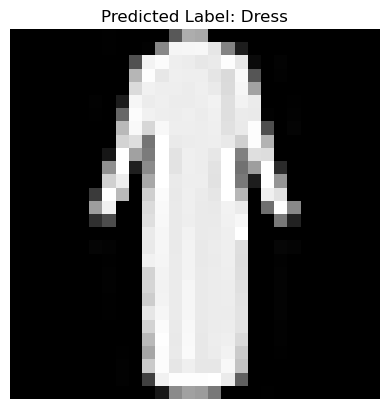

In [8]:
random_index = np.random.randint(len(X_test))
random_image = X_test[random_index]

display_prediction(random_image)